In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import TheilSenRegressor, LinearRegression
import pymannkendall as mk
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
def plot_correlation_matrix(comp_gridded, title=None):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(comp_gridded.T)
    
    # Define variable names
    var_names = ['Mar SWE', 'Mean Temp', 'Median Temp', 
                 'T5 - T50', 'T95 - T50', 'Climatology']
    
    # Create figure with appropriate size
    plt.figure(figsize=(6, 5))
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                xticklabels=var_names,
                yticklabels=var_names,
                cmap='RdBu_r',  # Red-Blue diverging colormap, reversed
                vmin=-1, vmax=1,  # Fix the range of correlations
                center=0,  # Center the colormap at zero
                annot=True,  # Show correlation values
                fmt='.2f',  # Format annotations to 2 decimal places
                square=True,  # Make the plot square
                cbar_kws={'label': 'Correlation Coefficient'})
    if title:
        plt.title(title)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Usage:
# fig = plot_correlation_matrix(comp_gridded)
# plt.show()

In [3]:
# i concatenated two chunks of codes here and you may find duplicate variables (t_50 and temp_median)
# but im too lazy to clean it up so bear with me
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]
climatology = np.mean(temp, axis=0)

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
t_50 = np.zeros((39, 90, 360))
t_95 = np.zeros((39, 90, 360))
t_5 = np.zeros((39, 90, 360))

for yy in range(39):
    left, right = yy*151, (yy+1)*151

    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

    t50 = np.percentile(temp[left:right, :, :], 50, axis=0)
    t95 = np.percentile(temp[left:right, :, :], 95, axis=0)
    t5 = np.percentile(temp[left:right, :, :], 5, axis=0)
    t_50[yy, :, :] = t50
    t_95[yy, :, :] = t95
    t_5[yy, :, :] = t5

# mask out nan values in temperatures
mask = 1 - np.isnan(np.mean(temp_mean, axis=0))
# the 1-deg mask (mask2) is downscaled from the 2-deg from Gottlieb 2024 et al.
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [4]:
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

comp_gridded = []
comp_insitu = []
climatology_group_map = np.zeros((90, 360))

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)
        
        lm_mean = TheilSenRegressor(random_state=42)
        lm_mean.fit(xx[:,None], temp_mean[:,i,j])

        # 50th, 95th, and 5th percentile trends
        lm50 = TheilSenRegressor(random_state=42)
        lm50.fit(xx[:,None], t_50[:,i,j])

        lm5 = TheilSenRegressor(random_state=42)
        lm5.fit(xx[:,None], t_5[:,i,j])

        lm95 = TheilSenRegressor(random_state=42)
        lm95.fit(xx[:,None], t_95[:,i,j])

        comp_gridded.append((swe_gridded[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if swe_insitu[i,j]:
            comp_insitu.append((swe_insitu[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if climatology[i,j] <= -20:
            climatology_group_map[i,j] = 1
        elif climatology[i,j] <= -10:
            climatology_group_map[i,j] = 2
        elif climatology[i,j] <= 0:
            climatology_group_map[i,j] = 3
        else:
            climatology_group_map[i,j] = 4

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)
# Create mask for rows where March SWE <= 2
mask_gridded = comp_gridded[:, 0] <= 2
comp_gridded = comp_gridded[mask_gridded]

mask_insitu = comp_insitu[:, 0] <= 2
comp_insitu = comp_insitu[mask_insitu]

# comp_gridded[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_gridded[:,1]: trend of mean temperature
# comp_gridded[:,2]: trend of median temperature
# comp_gridded[:,3]: cold tail outpacing
# comp_gridded[:,4]: warm tail outpacing
# comp_gridded[:,5]: climatological temperature
# same for comp_insitu        

Processing  1000  grids. Time taken so far:  39.30693745613098
Processing  2000  grids. Time taken so far:  79.99543929100037
Processing  3000  grids. Time taken so far:  121.08511757850647
Processing  4000  grids. Time taken so far:  162.04339337348938
Processing  5000  grids. Time taken so far:  203.96513032913208
Processing  6000  grids. Time taken so far:  246.83912897109985
Processing  7000  grids. Time taken so far:  290.8761863708496


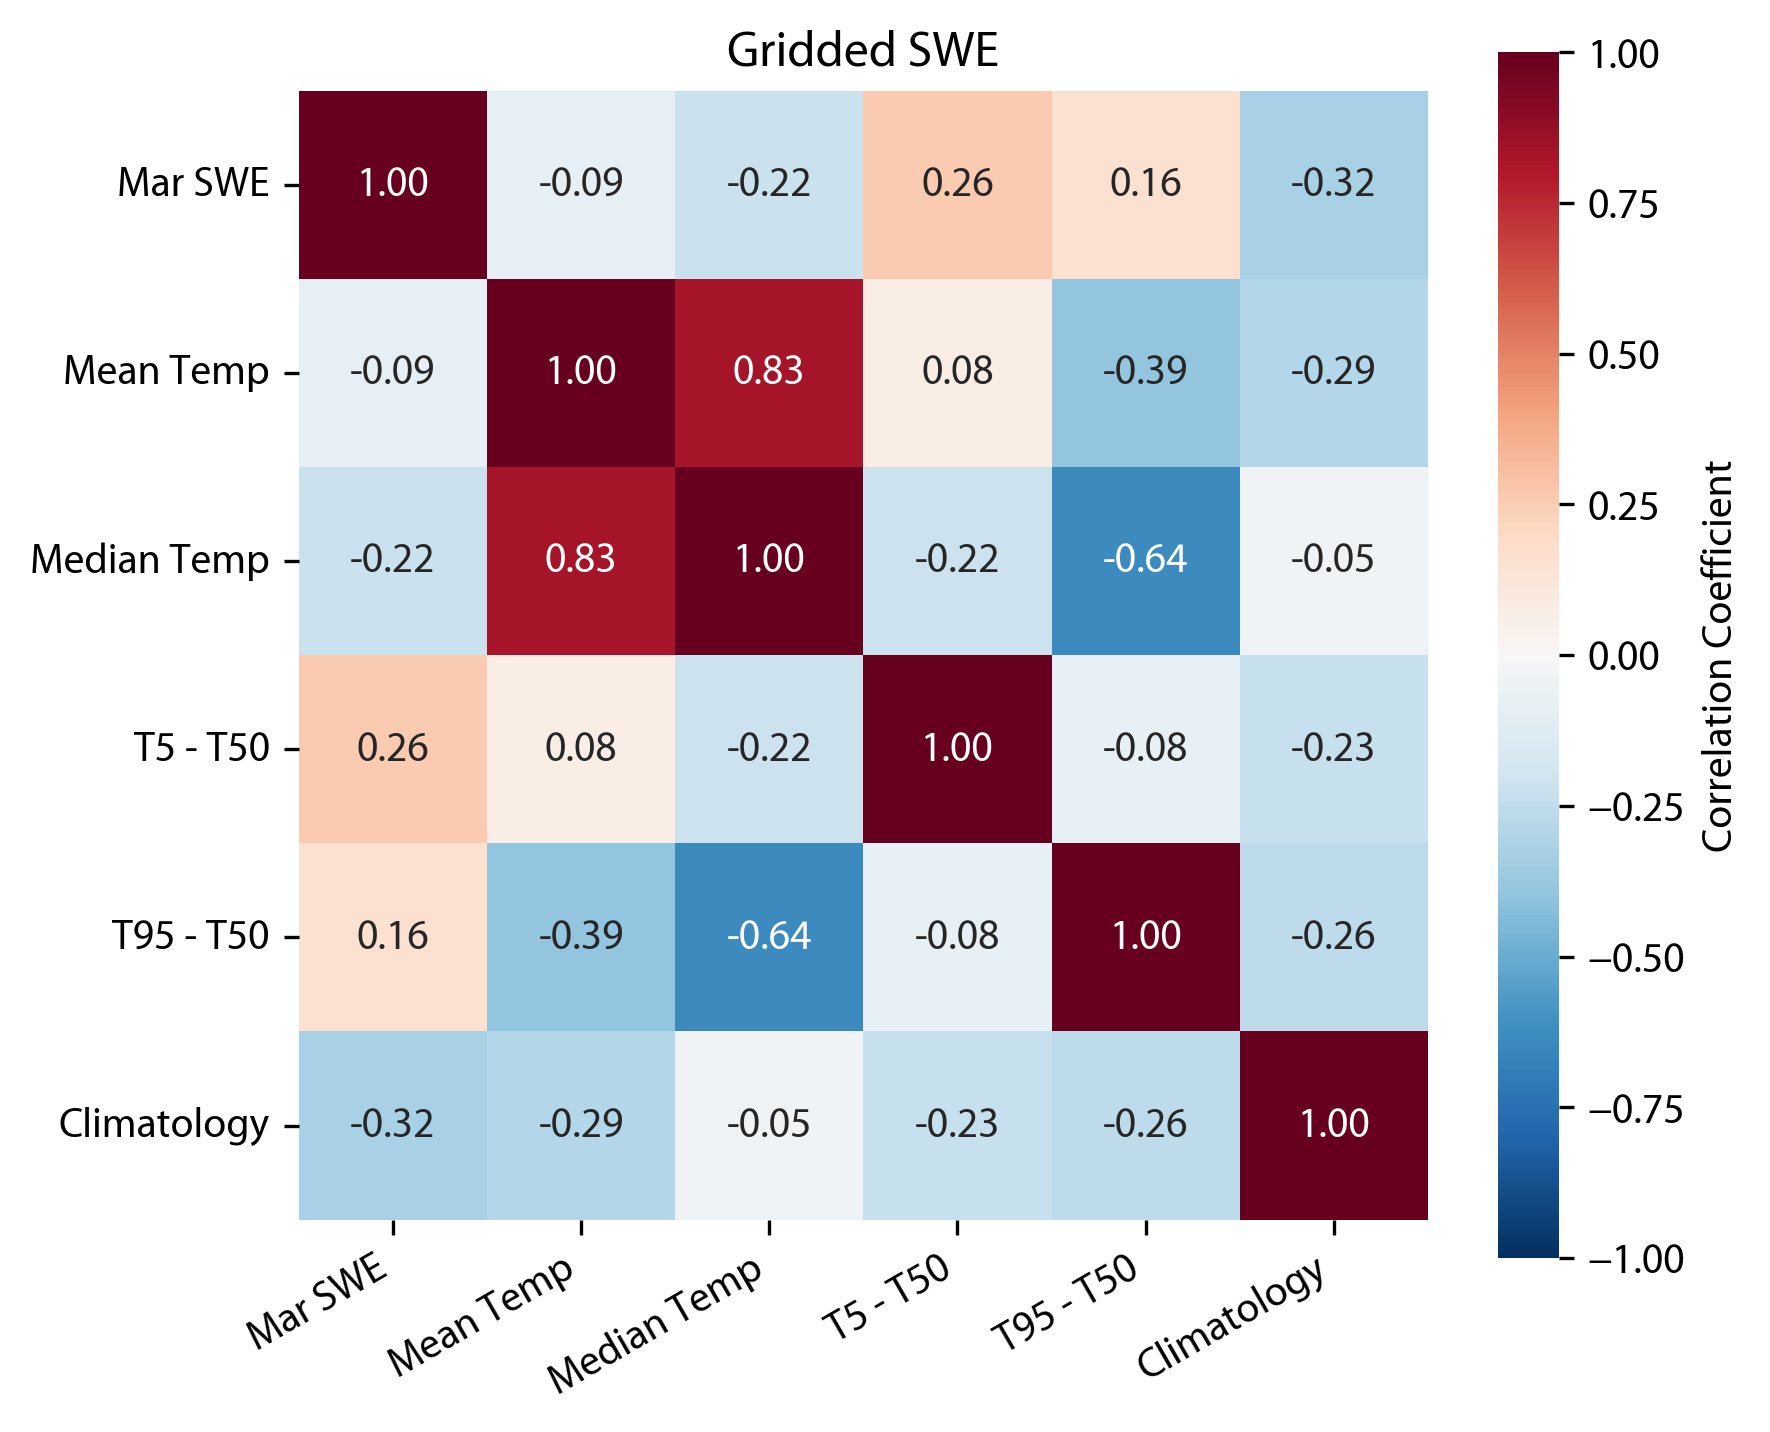

In [5]:
fig = plot_correlation_matrix(comp_gridded, title='Gridded SWE')
plt.show()
fig.savefig('figures_new/corr_gridded_swe.png')

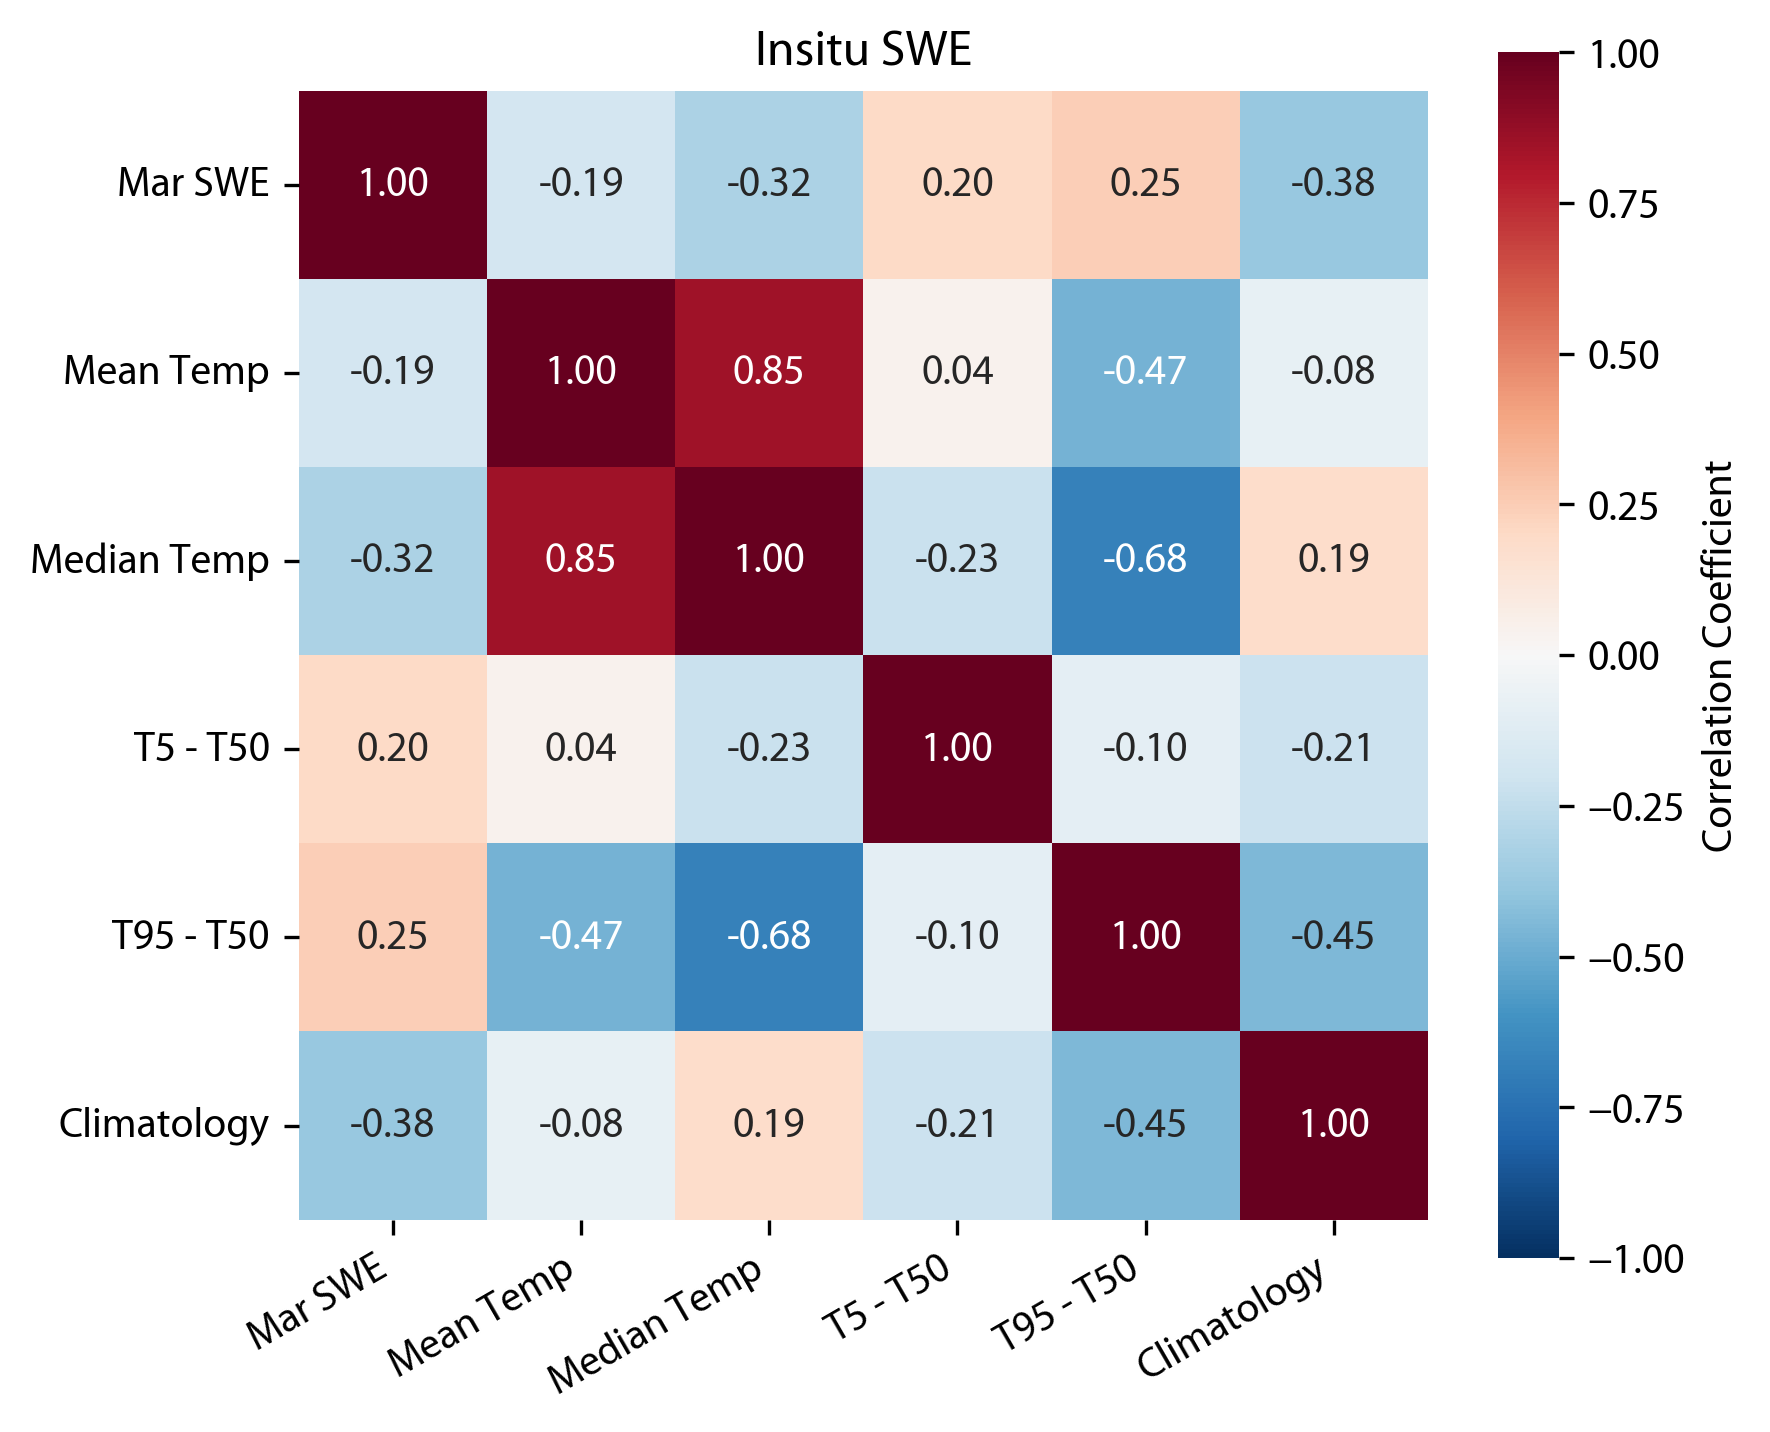

In [6]:
fig = plot_correlation_matrix(comp_insitu, title='Insitu SWE')
plt.show()
fig.savefig('figures_new/corr_insitu_swe.png')

In [7]:
XX = {}
# XX[0]: mean temperature
# XX[1]: median temperature
# XX[2]: median temperature + cold tail outpacing
# XX[3]: median temperature + warm tail outpacing
# XX[4]: median temperature + cold tail outpacing + warm tail outpacing
XX[0] = comp_gridded[:,1][:,None]
XX[1] = comp_gridded[:,2][:,None]
XX[2] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None]], axis=1)
XX[3] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,4][:,None]], axis=1)
XX[4] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None], 
                        comp_gridded[:,4][:,None]], axis=1)

for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_gridded[:,0])
    print(np.sqrt(lm.score(XX[i], comp_gridded[:,0])))

0.09360483964062359
0.22197406007485676
0.3136909693789605
0.22352028305850827
0.3280847265591333


In [8]:
XX = {}
# same as above but added climatology
XX[0] = np.concatenate([comp_gridded[:,1][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[1] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[2] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None],
                         comp_gridded[:,5][:,None]], axis=1)
XX[3] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,4][:,None],
                       comp_gridded[:,5][:,None]], axis=1)
XX[4] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None],
                        comp_gridded[:,4][:,None], comp_gridded[:,5][:,None]], axis=1)
for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_gridded[:,0])
    print(np.sqrt(lm.score(XX[i], comp_gridded[:,0])))

0.37943453809947675
0.40227906091877125
0.42726709967088805
0.4165137627656699
0.43027363132800756


In [9]:
XX = {}
XX[0] = comp_insitu[:,1][:,None]
XX[1] = comp_insitu[:,2][:,None]
XX[2] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None]], axis=1)
XX[3] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,4][:,None]], axis=1)
XX[4] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None], 
                        comp_insitu[:,4][:,None]], axis=1)
for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_insitu[:,0])
    print(np.sqrt(lm.score(XX[i], comp_insitu[:,0])))

0.1857529614669384
0.3164204934999878
0.3412697550457973
0.3195929108172098
0.3544581677609368


In [10]:
XX = {}
XX[0] = np.concatenate([comp_insitu[:,1][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[1] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[2] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None],
                        comp_insitu[:,5][:,None]], axis=1)
XX[3] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,4][:,None],
                        comp_insitu[:,5][:,None]], axis=1)
XX[4] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None], 
                        comp_insitu[:,4][:,None], comp_insitu[:,5][:,None]], axis=1)
for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_insitu[:,0])
    print(np.sqrt(lm.score(XX[i], comp_insitu[:,0])))

0.43473054674215955
0.4523470622290995
0.45796658832319886
0.4654252381608277
0.4658931355342412


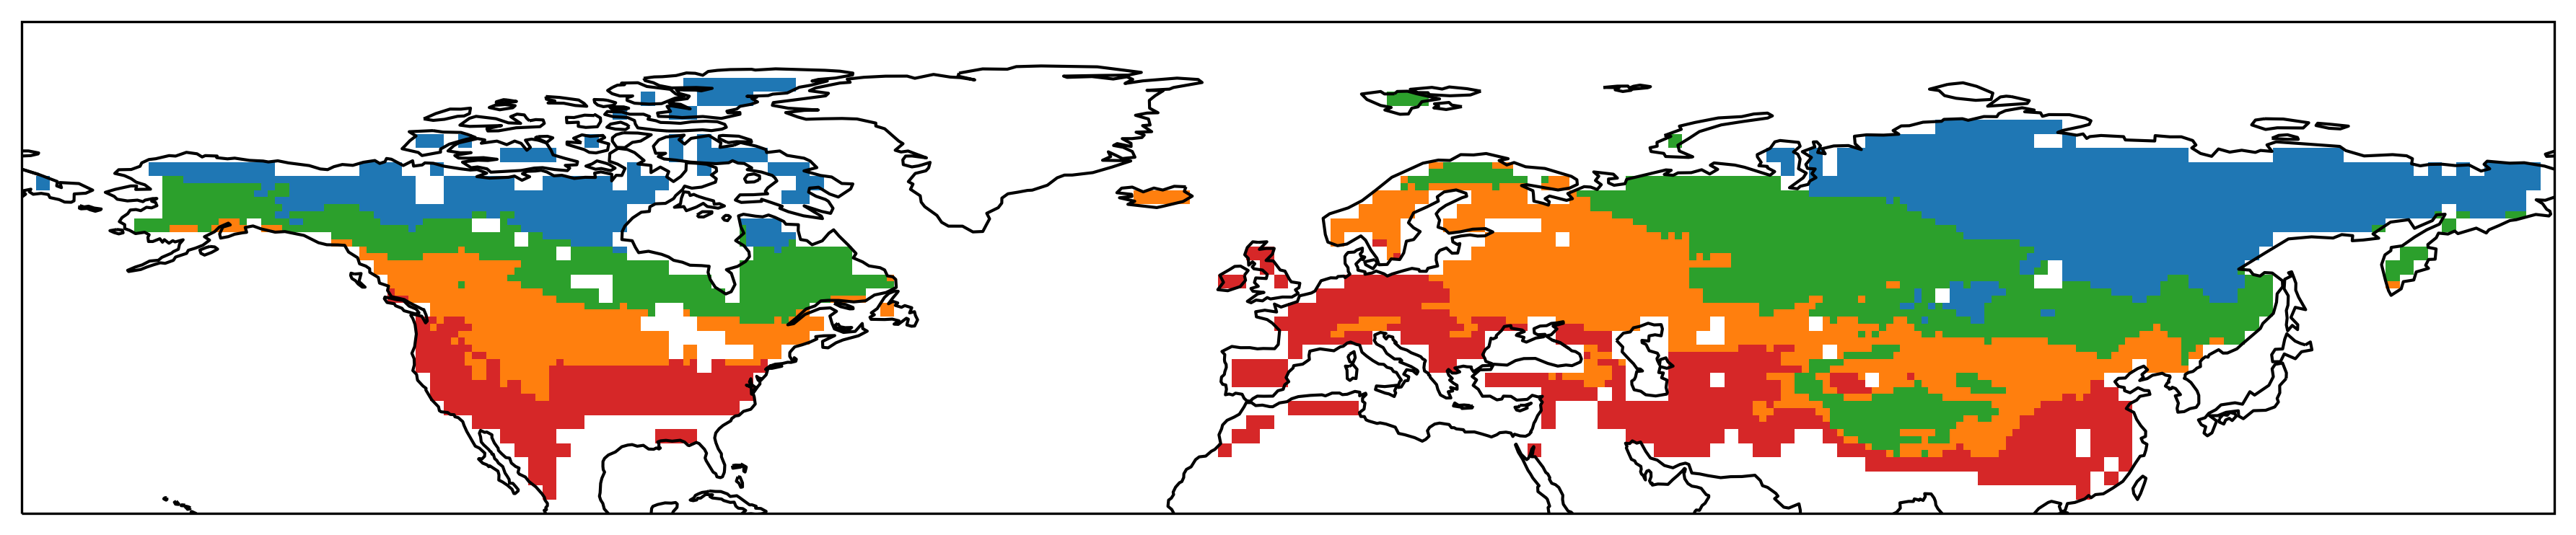

In [11]:

climatology_map_masked = np.ma.masked_where(mask == 0, climatology_group_map)
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)

# Create the plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(10, 12)

# Create main map
ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

# Create custom colormap for the 4 types
colors = ['#1f77b4',  # Type I: blue (stretch-stretch)
          '#2ca02c',  # Type II: green (shrink-shrink)
          '#ff7f0e',  # Type III: orange (shrink-stretch)
          '#d62728']  # Type IV: red (stretch-shrink)

cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(0.5, 5.5), ncolors=4)

# Plot the map
basemap = ax.pcolormesh(lon, lat, climatology_map_masked, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm)

# Add coastlines and gridlines
ax.coastlines()
# ax.gridlines()
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.savefig('figures_new/climatology_map.png')

In [12]:
# Define the bins and corresponding labels
bins = [-20, -10, 0]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(comp_gridded[:,5], bins)

comp_gridded_group = {}

for i in range(len(bins)+1):
    comp_gridded_group[i] = comp_gridded[grouped_indices == i, :]


In [13]:

def plot_incremental_skill(rr):
    # Create figure
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Define bar positions
    positions = np.arange(len(rr))
    
    # Define colors for different components
    base_color = '#3498db'  # Blue for baseline bars
    increment_color = '#2ecc71'  # Green for incremental improvements
    
    # Plot the first bar (mean temperature baseline)
    ax.bar(positions[0], rr[0], width=0.6, color='red')
    
    # Plot the second bar (median temperature baseline)
    ax.bar(positions[1], rr[1], width=0.6, color=base_color)
    
    # Plot incremental improvements for remaining bars
    for i in range(2, len(rr)):
        # Plot the baseline part (up to median temp skill)
        ax.bar(positions[i], rr[1], width=0.6, color=base_color)
        # Plot the incremental improvement
        ax.bar(positions[i], rr[i] - rr[1], width=0.6, bottom=rr[1], color=increment_color)
    
    # Add value labels on the bars
    for i, r in enumerate(rr):
        if i < 2:
            ax.text(positions[i], r, f'{r:.3f}', ha='center', va='bottom')
        else:
            increment = r - rr[1]
            tmp_text = f'+{increment:.3f}' if increment > 0 else f'{increment:.3f}'
            ax.text(positions[i], r, tmp_text, ha='center', va='bottom')
            
    ax.set_ylim(0, 0.5)
    # Customize the plot
    ax.set_xticks(positions)
    ax.set_xticklabels(['Mean ', 'Median ', 
                        '+ Cold',
                        '+ Warm',
                        '+ Both'], 
                       rotation=0, fontsize = 12)
    
    # Add labels and title
    ax.set_ylabel('R', fontsize=16)
    ax.set_yticks([])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

0.17080284106357352
0.16767540295797317
0.23159784485774143
0.28136079854231866
0.28852725206692237


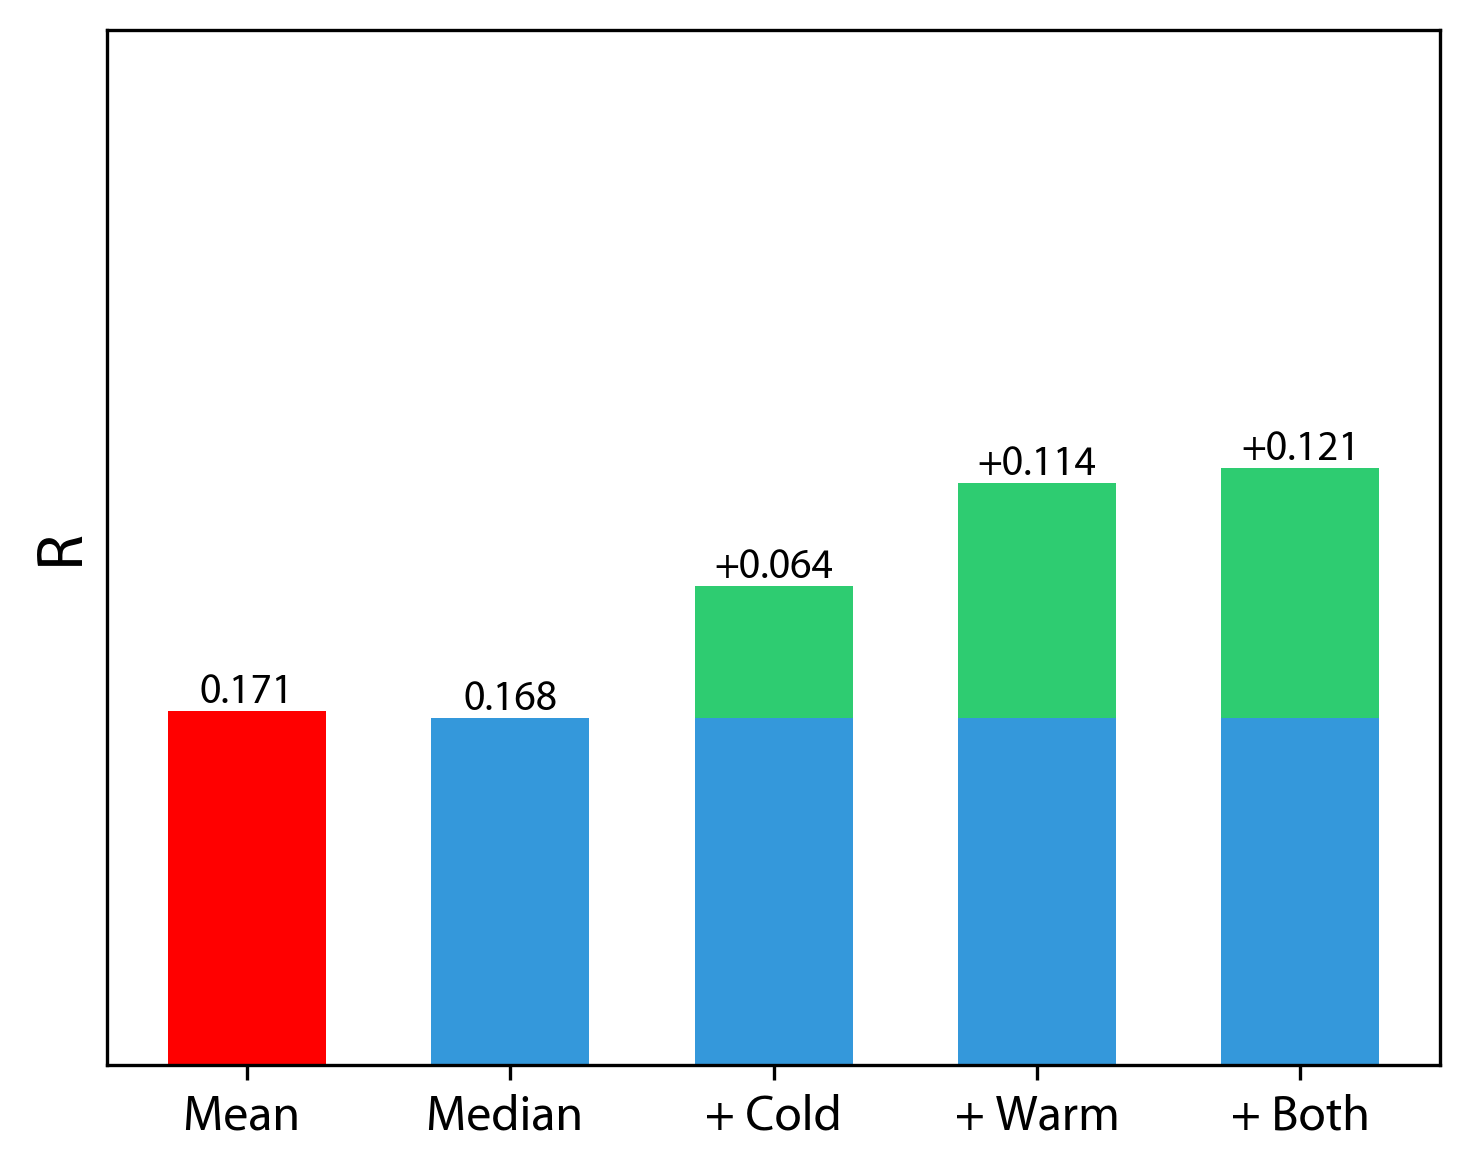

In [18]:
# Group index
k = 

# Create feature matrices for different model combinations
XX = {
    0: comp_gridded_group[k][:, 1:2],  # Single column, reshaped
    1: comp_gridded_group[k][:, 2:3],  # Single column, reshaped
    2: comp_gridded_group[k][:, [2,3]], # Two columns
    3: comp_gridded_group[k][:, [2,4]], # Two columns
    4: comp_gridded_group[k][:, [2,3,4]] # Three columns
}

# Calculate R scores for each model
rr = []
for i in range(5):
    # Fit linear regression and calculate R score
    lm = LinearRegression().fit(XX[i], comp_gridded_group[k][:, 0])
    r_score = np.sqrt(lm.score(XX[i], comp_gridded_group[k][:, 0]))
    rr.append(r_score)
    print(r_score)

# Plot and save results
fig = plot_incremental_skill(rr)
plt.show()
fig.savefig(f'figures_new/skill_group_{k+1}_doublecheck.png')

